#### 1 | Figure out exclusion criterion - talk w ryan : check numtrials excluded when cdiva processing txt files
#### 2| Re Run analysis (MANOVA(?)) w the following analysis: 

##### contrast
##### attention
##### 2f 4f (harmonic)
##### F1 and F2 
##### pre and post - there an effect of pre- post 
##### as a function of contrast, freq is there an eefect between pre post
##### get a p values for each of these to see if there is any quantifiable effect of data
##### enter raw data rahter than differnces 
##### plot differences and run analysis for pre post

In [1]:
# load packages
import numpy as np 
from scipy.io   import  loadmat
from scipy import stats
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from scipy.optimize import curve_fit 
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime

In [2]:
NumBins = 6 # number of contrasts
NumHarms = 2 # number of harmonic data: 2F1, 4F1
NumComp = 0 # first component from RCA
NumConds = 4
diff_ax = np.arange(0,NumBins) # plot differences

In [3]:
cp1 = sns.color_palette("Paired",12)
cp2 = sns.color_palette("cubehelix",12)# dark to light
sns.set_theme(context='notebook', style = 'darkgrid', palette=cp1)

In [5]:
# Main Directory of processed file from MatLab
#MainDir = 'D:\\AttnXV3_analysis\\RCA_F1\\AvgCRFs\\' # set dir
MainDir = 'C:\\plimon\\LTP_analysis\\RCA_F1\\AvgCRFs\\' # set dir
os.chdir(MainDir) # change old dir, to this dir
d = os.listdir(MainDir) # list files in dir
print(f'Files on hand: {d}')
##############################################
FileN = d[0] # choose one                        
file_path1 = os.path.join(MainDir, FileN) # join paths and prep 2 load
print('Current WD:',file_path1) # does path exist ... ?
print('Does File #1 Exist?',os.path.exists(file_path1)) # yes or no

Files on hand: ['AllCondCRF_AllSess_20240213_1141.pkl', 'F1AverageCRF_20240207_124816.pkl']
Current WD: C:\plimon\LTP_analysis\RCA_F1\AvgCRFs\AllCondCRF_AllSess_20240213_1141.pkl
Does File #1 Exist? True


In [6]:
loadData = pkl.load(open(file_path1,'rb'))
print(loadData.keys())

dict_keys(['Data', 'SubNames', 'VoiceMemo', 'DictMainKeys', 'ContLevs', 'crfLabs'])


In [7]:
data = loadData['Data']
data_labels = loadData['DictMainKeys']
SubNames = np.array(loadData['SubNames'])
note = loadData['VoiceMemo']
contrast_levels = loadData['ContLevs']
contrast_labs = loadData['crfLabs']
print(note)
NumSubs = int(len(SubNames))
print(data_labels) # labels for nr plots

['This file contains all subjects who did both sessions, avg of CRF [12x2] array, original crfs']
['attnL F1', 'attnL F2', 'attnR F1', 'attnR F2']


#### Functions

In [8]:
def GetDiffs(NumSubs, dictIn):
    """
    Get All post - pre amplitude differnces cross conditions and contrasts
    dictIn = key of dict data
    """
    aOut = np.zeros((NumSubs,NumBins*2)) # 55 x 12 
    for su in range(NumSubs):
        aIn = dictIn[su]
        AllDiffs = aIn[:,1] - aIn[:,0]
        aOut[su,:] = AllDiffs
    return aOut # 12x1 arry [0:6] 2f, [6:12] 4f
####################################################################################
def GetErrorBars(NumHarms,NumBins,NumSubs,dictIn):
   '''
   Get Error Bars for Data Vis.
   DataIn = XSubs x YBins array [25 x 12]
   DataOut = YBins-size Array
   '''
   err_bar_arr = np.zeros((NumHarms*NumBins)) # store errorbar info into NumBinxNumHarm-accomodating-size array
   for BinInd in range(NumBins*NumHarms):
      sObs_arr_perBin = np.zeros((NumSubs)) # store 1 val per subj
      for Sub_Obv in range(NumSubs):
         sObs_arr_perBin[Sub_Obv] = dictIn[Sub_Obv,BinInd]
      # Standard error of mean :  std of dataset / SampSize**2
      # est of uncertainty about dataset
      s1 = np.std(sObs_arr_perBin)
      err_bar = s1 / np.sqrt(NumSubs)
      err_bar_arr[BinInd] = err_bar
   return err_bar_arr

In [9]:
AllDiffs  = {} # 4 [nsubj * 12 array]
for co in range(NumConds):  
    AllDiffs[co] = GetDiffs(NumSubs,data[co])
    #print(AllDiffs[co].shape)

#### Vis Current Data and Exclude Particpants

-2.292885007244565 16
2671


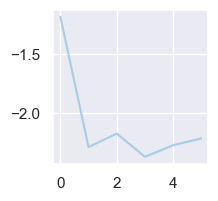

In [10]:
cond_ind = 1
bin_ind = 1

fig,axs = plt.subplots(1, figsize = (2,2), sharey=True)
dIn = AllDiffs[cond_ind][:,bin_ind] # because we start at 0 ...
NoisyVal, NoisySub = np.min(dIn,axis = 0), np.argmin(dIn, axis = 0)
print(NoisyVal,NoisySub)
print(SubNames[NoisySub])
axs.plot(diff_ax,AllDiffs[cond_ind][NoisySub,0:6])

In [11]:
Subarr = np.ones((NumSubs)) # empty subject boolean array
#rmv_subj_ind = ['2655','2670','2668','2671'] # subjects to remove 
rmv_subj_ind = ['2670','2671']
rmv_subj_ind = set(rmv_subj_ind)
# list comp to set identified badsubs to 0
GoodSubs = [0 if SubNames[i] in rmv_subj_ind else Subarr[i] for i in range(NumSubs)] # 1 = good subject

subject 2670 was excluded via VisInspect
subject 2671 was excluded via VisInspect
subject 2670 was excluded via VisInspect
subject 2671 was excluded via VisInspect
subject 2670 was excluded via VisInspect
subject 2671 was excluded via VisInspect
subject 2670 was excluded via VisInspect
subject 2671 was excluded via VisInspect


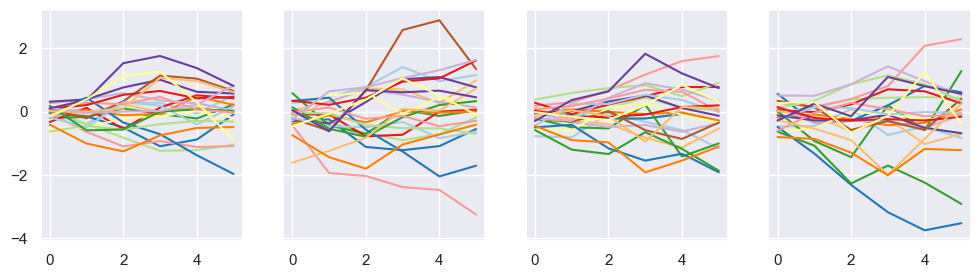

In [12]:
fig,axs = plt.subplots(1,4,figsize = (12,3), sharey=True)

for f_co in range(NumConds):
    for su in range(NumSubs):
        plot_ind = GoodSubs[su]
        if plot_ind == 1:
            dIn = AllDiffs[f_co]
            axs[f_co].plot(diff_ax,dIn[su,:6])
        else: 
            print(f'subject {SubNames[su]} was excluded via VisInspect')

#### Visualize Data

In [13]:
# fig,axs = plt.subplots(2,NumConds,figsize = (12,8), sharey = True)

# for co in range(NumConds):
#     for su in range(NumSubs):
#         plot_ind = GoodSubs[su]
#         if plot_ind == 1:
#             #axs[0,co].scatter(diff_ax,AllDiffs[co][su,:6], color = cp1[2])
#             axs[0,co].plot(diff_ax,AllDiffs[co][su,:6], color = cp1[4],alpha = 1/2)
#             axs[0,co].hlines(0, xmin = 0, xmax = 5, color = 'black',linewidth = 1)
#             axs[0,co].vlines(0, ymin = -1/2, ymax = 1/2, color = 'black',linewidth = 1/2)

#             #axs[1,co].scatter(diff_ax,AllDiffs[co][su,6:],color = cp1[1])
#             axs[1,co].plot(diff_ax,AllDiffs[co][su,6:],color = cp1[7],alpha = 1/2)
#             axs[1,co].hlines(0, xmin = 0, xmax = 5, color = 'black',linewidth = 1)
#             axs[1,co].vlines(0, ymin = -1/2, ymax = 1/2, color = 'black',linewidth = 1/2)

#             axs[0,co].set_title(f'{data_labels[co]}')

#             axs[0,co].set_xticks(range(len(contrast_levels)))
#             axs[0,co].set_xticklabels(contrast_labs)

#             axs[1,co].set_xticks(range(len(contrast_levels)))
#             axs[1,co].set_xticklabels(contrast_labs)
#         else:
#             print(f'subject {SubNames[su]} was excluded via VisInspect')
# plt.suptitle(f'Net Response Differences Post - Pre')
# fig.tight_layout()
# plt.show()

#### Get Average of Post - Pre Amplitudes

In [14]:
AvgDiffs = {}

for co in range(NumConds):
    AvgDiffs[co] = np.mean(AllDiffs[co],axis = 0)

(12,)


#### Compute Error Bars

In [15]:
AllErrBarVals = np.zeros((NumConds,NumBins*NumHarms)) # 4x 12 arr

for co in range(NumConds):
    AllErrBarVals[co,:] = GetErrorBars(NumHarms,NumBins,NumSubs, dictIn = AllDiffs[co])

#### Visualize Average Differences 

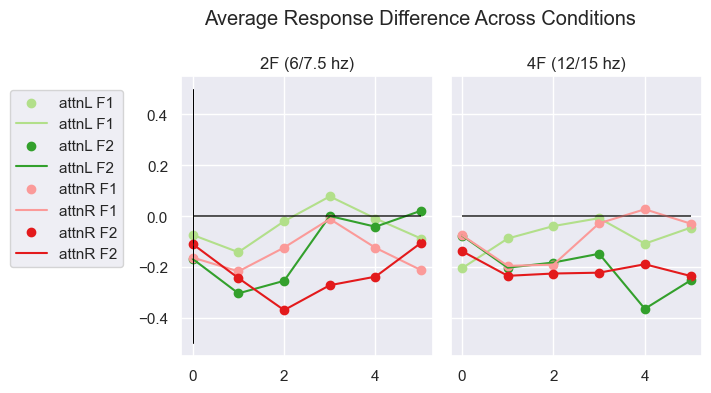

In [16]:
fig,axs = plt.subplots(1,2,figsize=(6,4),sharey=True, sharex = True)
for i in range(NumConds):
    axs[0].scatter(diff_ax,AvgDiffs[i][:6], label = f'{data_labels[i]}', color = cp1[i+2])
    axs[0].plot(diff_ax,AvgDiffs[i][:6], label = f'{data_labels[i]}', color = cp1[i+2])

    axs[1].scatter(diff_ax,AvgDiffs[i][6:], label = f'{data_labels[i]}', color = cp1[i+2])
    axs[1].plot(diff_ax,AvgDiffs[i][6:], label = f'{data_labels[i]}', color = cp1[i+2])

    axs[0].hlines(0,xmin=0,xmax=5,color='black',linewidth = 1/3)
    axs[1].hlines(0,xmin=0,xmax=5,color='black',linewidth = 1/3)
    axs[0].vlines(0,ymin=-1/2,ymax=1/2,color ='black',linewidth=1/2)

    axs[0].set_title(f'2F (6/7.5 hz)')
    axs[1].set_title(f'4F (12/15 hz)')

plt.suptitle(f'Average Response Difference Across Conditions')
plt.tight_layout()
axs[0].legend(loc = 'upper right',fontsize=9)
axs[0].legend(loc='upper right', bbox_to_anchor=(-0.2, 0.98))

#### Plot with ErrorBars

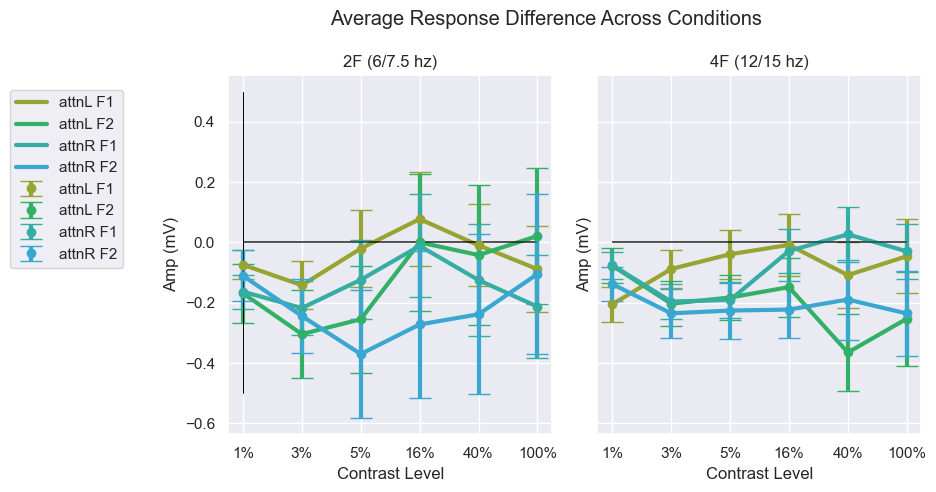

In [29]:
cp1 = sns.color_palette("husl", 8)

fig,axs = plt.subplots(1,2,figsize=(8,5),sharey=True, sharex = True)
for i in range(NumConds):
    axs[0].plot(diff_ax,AvgDiffs[i][:6], label = f'{data_labels[i]}', color = cp1[i+2],linewidth = 3)
    axs[0].errorbar(diff_ax,AvgDiffs[i][:6],yerr=AllErrBarVals[i,:6],fmt='o',label=f'{data_labels[i]}',color = cp1[i+2],capsize = 8, linewidth = 3)
    axs[0].set_xlabel(f'Contrast Level')
    axs[0].set_ylabel(f'Amp (mV)')
    
    axs[1].plot(diff_ax,AvgDiffs[i][6:], label = f'{data_labels[i]}', color = cp1[i+2], linewidth = 3)
    axs[1].errorbar(diff_ax,AvgDiffs[i][6:],yerr=AllErrBarVals[i,6:],fmt='o',label = f'{data_labels[i]}', color = cp1[i+2],capsize = 8, linewidth = 3)
    axs[1].set_xlabel(f'Contrast Level')
    axs[1].set_ylabel(f'Amp (mV)')

    axs[0].hlines(0,xmin=0,xmax=5,color='black',linewidth = 1/3)
    axs[1].hlines(0,xmin=0,xmax=5,color='black',linewidth = 1/3)
    axs[0].vlines(0,ymin=-1/2,ymax=1/2,color ='black',linewidth=1/2)

    axs[0].set_title(f'2F (6/7.5 hz)')
    axs[1].set_title(f'4F (12/15 hz)')
##########################################################################################################################################################
axs[0].set_xticks(range(len(contrast_levels)))
axs[0].set_xticklabels(contrast_labs)
axs[1].set_xticks(range(len(contrast_levels)))
axs[1].set_xticklabels(contrast_labs)
plt.suptitle(f'Average Response Difference Across Conditions')
plt.tight_layout()
axs[0].legend(loc = 'upper right',fontsize=9)
axs[0].legend(loc='upper right', bbox_to_anchor=(-0.3, 0.98))

subject 2670 was excluded via VisInspect
subject 2671 was excluded via VisInspect
subject 2670 was excluded via VisInspect
subject 2671 was excluded via VisInspect
subject 2670 was excluded via VisInspect
subject 2671 was excluded via VisInspect
subject 2670 was excluded via VisInspect
subject 2671 was excluded via VisInspect


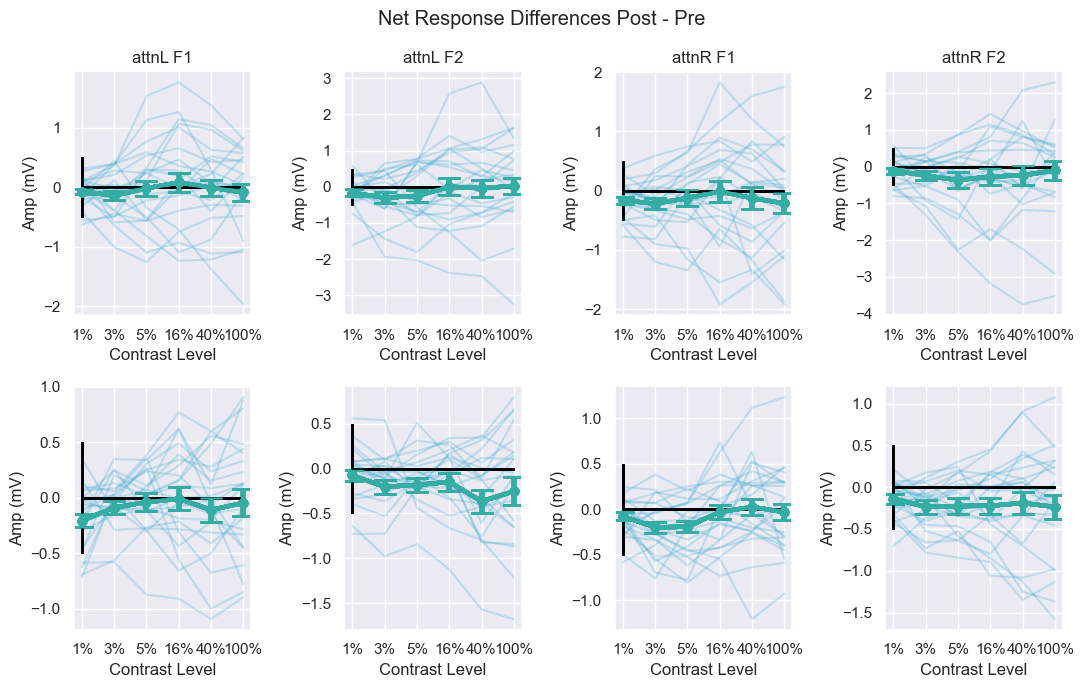

In [60]:
fig,axs = plt.subplots(2,NumConds,figsize = (11,7), sharey = False)

for co in range(NumConds):
    for su in range(NumSubs):
        plot_ind = GoodSubs[su]
######################################################################################################################
        if plot_ind == 1:
            #axs[0,co].scatter(diff_ax,AllDiffs[co][su,:6], color = cp1[2])
            axs[0,co].plot(diff_ax,AllDiffs[co][su,:6], color = cp1[5],alpha = 0.25)
            axs[0,co].hlines(0, xmin = 0, xmax = 5, color = 'black',linewidth = 1)
            # plt avgs
            axs[0,co].plot(diff_ax,AvgDiffs[co][:6], label = f'{data_labels[i]}', color = cp1[4],linewidth = 3)
            # plot avg with error bars 
            axs[0,co].errorbar(diff_ax,AvgDiffs[co][:6], yerr = AllErrBarVals[co,:6], fmt = 'o', label = f'{data_labels[co]}', color = cp1[4],capsize = 8, linewidth = 3)
            #axs[0,co].scatter(diff_ax,AvgDiffs[co][:6], label = f'{data_labels[i]}', color = cp1[5],linewidth = 3)
            axs[0,co].vlines(0, ymin = -1/2, ymax = 1/2, color = 'black',linewidth = 1)
            axs[0,co].set_xlabel(f'Contrast Level')
            axs[0,co].set_ylabel(f'Amp (mV)')
            ###########################################################################################################
            #axs[1,co].scatter(diff_ax,AllDiffs[co][su,6:],color = cp1[1])
            axs[1,co].plot(diff_ax,AllDiffs[co][su,6:],color = cp1[5],alpha = 0.25)
            axs[1,co].hlines(0, xmin = 0, xmax = 5, color = 'black',linewidth = 1)
            axs[1,co].vlines(0, ymin = -1/2, ymax = 1/2, color = 'black',linewidth = 1)
            # plt avgs
            axs[1,co].plot(diff_ax,AvgDiffs[co][6:], label = f'{data_labels[i]}', color = cp1[4],linewidth = 3)
            axs[1,co].errorbar(diff_ax,AvgDiffs[co][6:], yerr = AllErrBarVals[co,6:], fmt = 'o', label = f'{data_labels[co]}', color = cp1[4],capsize = 8, linewidth = 3)
            #axs[1,co].scatter(diff_ax,AvgDiffs[co][6:], label = f'{data_labels[i]}', color = cp1[5],linewidth = 3)
            axs[1,co].set_xlabel(f'Contrast Level')
            axs[1,co].set_ylabel(f'Amp (mV)')
#######################################################################################################################
            axs[0,co].set_title(f'{data_labels[co]}')
            axs[0,co].set_xticks(range(len(contrast_levels)))
            axs[0,co].set_xticklabels(contrast_labs)
            axs[1,co].set_xticks(range(len(contrast_levels)))
            axs[1,co].set_xticklabels(contrast_labs)
        else:
            print(f'subject {SubNames[su]} was excluded via VisInspect')
plt.suptitle(f'Net Response Differences Post - Pre')
fig.tight_layout()
plt.show()

#### Save Data

In [ ]:
DictOut={}

note = ['Cont:Post - pre responses for all conditions for all subs, sub x contrast diff']

DictOut['DiffData'] = AllDiffs
DictOut['SubNames'] = SubNames
DictOut['DictMainKeys'] = data_labels
DictOut['ContLevs'] = contrast_levels
DictOut['crfLabs'] = contrast_labs
DictOut['VoiceMemo'] = note

#### Set and Save Data Dir

In [ ]:
SaveDataDir = 'C:\\plimon\\LTP_analysis\\RCA_F1\\AmpResponseDiffs\\'
FileOutName = 'PostPreResponseDifferences'
#####################################################
dnt = datetime.now()
fdnt = dnt.strftime("%Y%m%d_%H%M") # lil date seal xoxo
FileN = f'{FileOutName}_{fdnt}.pkl'

NewFilePath = os.path.join(SaveDataDir, FileN)
print(NewFilePath)

if not os.path.exists(SaveDataDir):
    os.makedirs(SaveDataDir)
    print(f'Path to Saved File is {NewFilePath}')

In [ ]:
SaveFile = 'n'

if SaveFile == 'y':
    with open(NewFilePath, 'wb') as file:
        pkl.dump(DictOut, file, protocol=pkl.HIGHEST_PROTOCOL)

        print('Data Saved!!')
else:
    print('Did not save file!')
